# 数据处理

In [49]:
from itertools import groupby

# 载入必要工具，尤其是gensim.models中的Word2Vec
import pandas as pd
import numpy as np
from dask.array import optimize
from dask.graph_manipulation import checkpoint
from gensim.models import Word2Vec
from tensorflow.python.keras.saving.saved_model.serialized_attributes import metrics
from tensorflow.python.profiler.profiler_client import monitor


In [ ]:
#读取数据，并做好分组
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

#创建测试集预训练集
train_Y = train_df.label
train_X = train_df.content
test_Y = test_df.label
test_X = test_df.content

#创建字典，方便编号与罪行对应
dict = {232:"故意杀人罪",233:"过失致人死亡罪",234:"故意伤害罪",235:"过失致人重伤罪"}  

In [113]:
#将Y数据进行编码
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# 使用 LabelEncoder 将标签转换为从0开始的连续整数
le = LabelEncoder()
all_labels = np.concatenate([train_Y, test_Y])
le.fit(all_labels)

train_Y_encoded = le.transform(train_Y)
test_Y_encoded = le.transform(test_Y)

# 获取实际的类别数量
num_classes = len(le.classes_)
print(f"实际类别数量: {num_classes}")

# 使用正确的类别数量进行 one-hot 编码
train_YY = to_categorical(train_Y_encoded, num_classes=num_classes)
test_YY = to_categorical(test_Y_encoded, num_classes=num_classes)

print(f"编码后形状 - 训练: {train_YY.shape}, 测试: {test_YY.shape}")

实际类别数量: 4
编码后形状 - 训练: (6000, 4), 测试: (1999, 4)


In [142]:
print("原Y的编码：",le.classes_)
print("现在Y对应的编码",set(train_Y_encoded))
print("对应的犯罪类型",dict.values())

原Y的编码： [232 233 234 235]
现在Y对应的编码 {0, 1, 2, 3}
对应的犯罪类型 dict_values(['故意杀人罪', '过失致人死亡罪', '故意伤害罪', '过失致人重伤罪'])


In [50]:
#导入jieba，切分句子,并将训练集X句子进行切分存储
import jieba                                 
train_splitX = []                              
for line in train_X:                    
    line_fenci = jieba.lcut(line)            
    train_splitX .append(line_fenci) 


In [138]:
print("分词结果如下：")
print(train_splitX[0])

分词结果如下：
['山东省', '淄博市', '周村区', '人民法院', ' ', '\n', '\n', '刑', ' ', '事', ' ', '判', ' ', '决', ' ', '书', ' ', '\n', '\n', '(', '2016', '）', '鲁', '0306', '刑初', '384', '号', ' ', '\n', '\n', '公诉', '机关', '淄博市', '周村区', '人民检察院', '。', ' ', '\n', '\n', '被告人', '周某', '，', '男', '，', '因涉嫌', '犯', '故意伤害罪', '于', '2016', '年', '8', '月', '9', '日', '被', '淄博市', '公安局', '周村', '分局', '刑事拘留', '，', '同年', '8', '月', '19', '日', '被', '取保候审', '。', ' ', '\n', '\n', '辩护人', '张承科', '，', '山东', '绍荣', '律师', '事务所律师', '。', ' ', '\n', '\n', '淄博市', '周村区', '人民检察院', '以', '周检', '公诉', '刑诉', '[', '2016', ']', '355', '号', '起诉书', '指控', '被告人', '周某', '犯', '故意伤害罪', '，', '于', '2016', '年', '11', '月', '15', '日向', '本院', '提起公诉', '，', '本院', '于', '同日', '立案', '，', '依法', '组成', '合议庭', '，', '适用', '简易程序', '，', '公开', '开庭', '进行', '了', '审理', '。', '淄博市', '周村区', '人民检察院', '指派', '检察员', '赵迎', '出庭', '支持', '公诉', '，', '被告人', '周某', '及其', '辩护人', '张承科', '到庭', '参加', '诉讼', '。', '现已', '审理', '终结', '。', ' ', '\n', '\n', '淄博市', '周村区', '人民检察院', '指控', '：', ' ', '\n', '\n', '

# Embedding

In [56]:
#定义向量并拟合词向量
DIM = 100
model = Word2Vec(train_splitX, vector_size=DIM, min_count=5)
contents = model.wv.index_to_key


In [188]:
model.wv['伤害']  

array([-2.5333283 ,  0.7174999 , -0.3554736 , -1.085698  , -1.76761   ,
        1.0212412 , -1.4053136 , -1.8411657 , -1.1159027 ,  1.1916603 ,
       -1.1403146 , -1.2804068 , -1.2729243 ,  2.069345  , -1.1283201 ,
       -1.1828064 ,  0.08155464, -1.8905635 ,  0.3815302 , -0.55635834,
       -0.44701138, -0.31785893, -0.02320763, -1.1618582 , -0.57794493,
       -0.248708  ,  0.5775533 , -1.9330609 ,  1.5357759 ,  1.7690188 ,
        1.1072242 ,  0.7691786 , -0.7538502 , -2.257199  , -2.5404274 ,
       -0.0951841 , -0.94864166, -0.42291206, -0.75401807, -0.937585  ,
        0.97031516, -1.191572  ,  1.3511834 ,  2.4522777 , -0.7337071 ,
        2.6793404 ,  2.993505  , -0.2641009 ,  0.04620513, -1.2450471 ,
       -1.7954776 ,  2.4628356 ,  1.4325951 , -0.9487596 ,  0.96641815,
       -1.6810396 ,  0.03581965,  0.29427928, -0.21128272, -2.0004163 ,
       -0.6515189 ,  2.0772114 , -1.1141993 ,  0.52574354,  0.24344037,
       -0.9563238 , -0.32604665,  0.50189096,  0.59721535, -1.50

In [57]:
#切分句子,并将测试集X句子进行切分存储
test_splitX = []                              
for line in test_X:                    
    line_fenci = jieba.lcut(line)            
    test_splitX .append(line_fenci) 

# 整理数据

In [84]:
# 准备训练数据
# 初始化一个全零矩阵，行数为训练集句子数量，列数为词向量维度
train_splitX_sum = np.zeros([len(train_splitX), DIM])

# 遍历每个句子及其索引
for idx, line in enumerate(train_splitX):
    print(f'开始第{idx+1}个数据，共{len(train_splitX)}个数据')
    # 初始化一个临时向量，用于累加当前句子的词向量
    temp_vector = np.zeros(DIM)
    for word in line:
        cc = 0
        # 累加每个词的词向量
        if word in contents :
            temp_vector += model.wv[word]
            cc += 1

    # 计算平均向量
        temp_vector /= cc
    print(f'结束第{idx+1}个数据')
    # 将平均向量赋值给对应的行
    train_splitX_sum[idx, :] = temp_vector

In [83]:
#准备测试数据集
test_splitX_sum = np.zeros([len(test_splitX), DIM])

# 遍历每个句子及其索引,利用序号与内容两个信息进行遍历
for idx, line in enumerate(test_splitX):
    print(f'开始第{idx+1}个数据，共{len(test_splitX)}个数据')
    # 初始化一个临时向量，用于累加当前句子的词向量
    temp_vector = np.zeros(DIM)
    for word in line:
        cc = 0
        # 累加每个词的词向量
        if word in contents :
            temp_vector += model.wv[word]
            cc += 1

    # 计算平均向量
        temp_vector /= cc
    print(f'结束第{idx+1}个数据')
    # 将平均向量赋值给对应的行
    test_splitX_sum[idx, :] = temp_vector

# 构建模型

## 模型思路：将每个content的所有词向量矩阵加和平均作为X，罪行为Y
### 采用1维卷积神经网络

In [123]:
from keras.layers import Dense,Flatten,Input,Activation,Conv1D
from keras.layers import MaxPool1D,BatchNormalization,Reshape
from keras import Model
ConLayer = 100
ConNumber = 3
NurNumber = 50
DenNumber = 3

input_size = [100]
input_layer = Input(input_size)
x = input_layer
x = BatchNormalization()(x)

# 将2D输入转换为3D格式：添加一个维度作为特征维度
# 形状从 (None, 100) 变为 (None, 100, 1)
x = Reshape((100, 1))(x)
for i in range(ConNumber):
    x = Conv1D(filters=ConLayer, kernel_size=3, padding="same", activation="relu")(x)
    x = MaxPool1D(pool_size=2)(x)

x= Flatten()(x)

for i in range(DenNumber):
    x = Dense(NurNumber,activation="relu")(x)

x = Dense(4,activation="softmax")(x)
output_layer = x
Premodel = Model(input_layer,output_layer)
Premodel.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 100)       │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 100)        │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 100)        │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        60,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,354 (493.57 KB)

 Trainable params: 126,154 (492.79 KB)

 Non-trainable params: 200 (800.00 B)

# 编译与训练

In [126]:
from tensorflow.keras.optimizers import Adam

Premodel.compile(optimizer= Adam(0.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(
             "best_PreModel.h5",
             monitor="val_accuracy",
            save_best_only = True,
            verbose = 1
)

early_stop = EarlyStopping(
             monitor="val_accuracy",
             patience = 10,
             restore_best_weights = True,
             verbose = 1
)

# 开始训练

In [135]:

history1 = Premodel.fit(train_splitX_sum, train_YY,
    validation_data=(test_splitX_sum, test_YY),
    batch_size=6000,
    epochs=1000,
    callbacks=[checkpoint,early_stop]
)

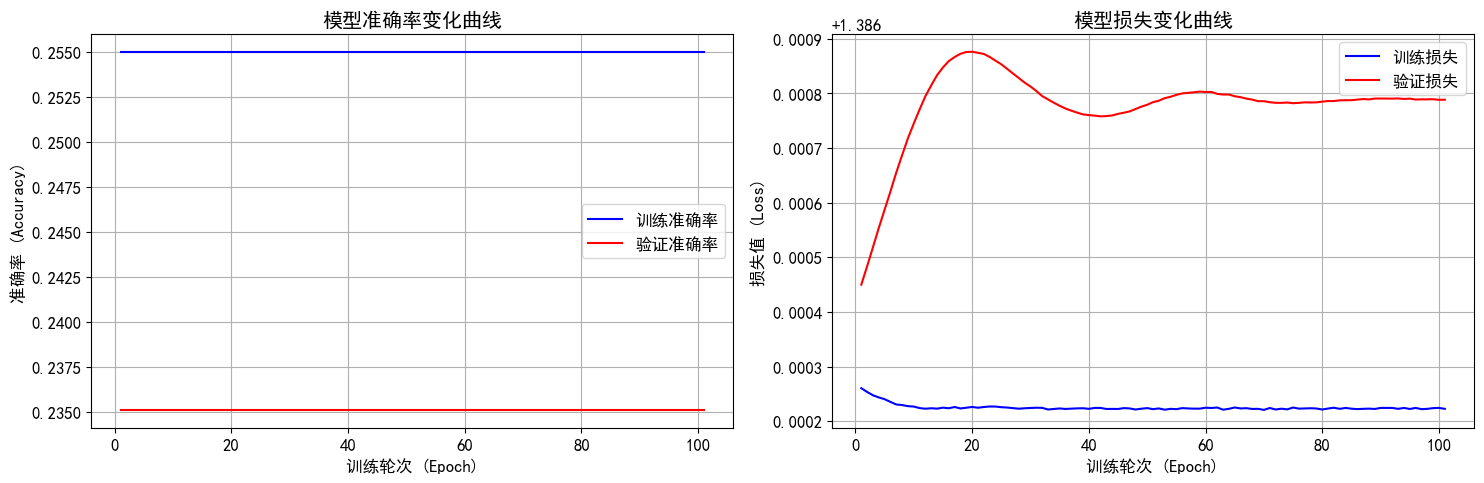

In [132]:
#绘图检查训练效果
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.rcParams['font.size'] = 12      
def plot_training_history(history1, history2):
    """
    绘制训练过程中的准确率和损失曲线
    
    参数:
    history1: 第一阶段训练历史
    history2: 第二阶段训练历史
    """
    # 创建1行2列的子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 合并两个阶段的训练历史
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    # 创建epoch范围
    epochs_range = range(1, len(acc) + 1)
    
    # 绘制准确率曲线
    ax1.plot(epochs_range, acc, 'b-', label='训练准确率')
    ax1.plot(epochs_range, val_acc, 'r-', label='验证准确率')
    ax1.set_title('模型准确率变化曲线')
    ax1.set_xlabel('训练轮次 (Epoch)')
    ax1.set_ylabel('准确率 (Accuracy)')
    ax1.legend()  # 显示图例
    ax1.grid(True)  # 显示网格
    
    # 绘制损失曲线
    ax2.plot(epochs_range, loss, 'b-', label='训练损失')
    ax2.plot(epochs_range, val_loss, 'r-', label='验证损失')
    ax2.set_title('模型损失变化曲线')
    ax2.set_xlabel('训练轮次 (Epoch)')
    ax2.set_ylabel('损失值 (Loss)')
    ax2.legend()  # 显示图例
    ax2.grid(True)  # 显示网格
    
    # 自动调整子图间距
    plt.tight_layout()
    # 显示图形
    plt.show()

# 绘制训练历史图表
plot_training_history(history, history1)

## 小结：  
可见模型比较差 预测结果不如随机猜测，接下来考虑改进X，将X进行分段，形成层若干词向量矩阵，再做输入，进行训练

# 改进数据分段采集与模型优化

In [159]:
def create_uniform_segments(sentences, labels, num_segments=5, segment_length=10):
    """
    从句子中均匀采样固定数量的分段
    """
    all_segments = []
    all_labels = []
    
    for sentence, label in zip(sentences, labels):
        sentence_segments = []
        
        if len(sentence) <= segment_length:
            # 句子短于分段长度，直接使用整个句子
            segment = sentence + ['<PAD>'] * (segment_length - len(sentence))
            sentence_segments = [segment] * num_segments
        else:
            # 从长句子中均匀采样分段
            available_positions = len(sentence) - segment_length + 1
            step = max(1, available_positions // num_segments)
            
            for i in range(num_segments):
                start = min(i * step, available_positions - 1)
                segment = sentence[start:start+segment_length]
                sentence_segments.append(segment)
        
        all_segments.extend(sentence_segments)
        all_labels.extend([label] * num_segments)
    
    return all_segments, all_labels

In [160]:
def create_overlapping_segments(sentences, labels, num_segments=5, segment_length=10):
    """
    使用重叠滑动窗口创建分段
    """
    all_segments = []
    all_labels = []
    
    for sentence, label in zip(sentences, labels):
        sentence_segments = []
        
        if len(sentence) <= segment_length:
            # 短句子处理
            segment = sentence + ['<PAD>'] * (segment_length - len(sentence))
            sentence_segments = [segment] * num_segments
        else:
            # 计算滑动步长
            total_overlap = segment_length * num_segments - len(sentence)
            if total_overlap <= 0:
                step_size = 1  # 最大重叠
            else:
                step_size = max(1, (len(sentence) - segment_length) // (num_segments - 1))
            
            # 生成分段
            for i in range(num_segments):
                start = min(i * step_size, len(sentence) - segment_length)
                segment = sentence[start:start+segment_length]
                sentence_segments.append(segment)
        
        all_segments.extend(sentence_segments)
        all_labels.extend([label] * num_segments)

In [161]:
def process_data_with_fixed_segments(train_sentences, train_labels, test_sentences, test_labels, 
                                   model, num_segments=5, segment_length=10, DIM=100):
    """
    完整的数据处理流程：分段 → 计算平均向量 →  reshape为固定维度
    """
    
    # 1. 创建分段
    print("创建训练数据分段...")
    train_segments, train_segment_labels = create_uniform_segments(
        train_sentences, train_labels, num_segments, segment_length
    )
    
    print("创建测试数据分段...")
    test_segments, test_segment_labels = create_uniform_segments(
        test_sentences, test_labels, num_segments, segment_length
    )
    
    print(f"训练分段数: {len(train_segments)}")
    print(f"测试分段数: {len(test_segments)}")
    
    # 2. 计算分段向量
    def compute_segment_ectors_batch(segments, model, DIM):
        vectors = np.zeros([len(segments), DIM])
        for idx, segment in enumerate(segments):
            temp_vector = np.zeros(DIM)
            valid_words = 0
            for word in segment:
                if word != '<PAD>' and word in model.wv:
                    temp_vector += model.wv[word]
                    valid_words += 1
            if valid_words > 0:
                vectors[idx] = temp_vector / valid_words
        return vectors
    
    print("计算分段向量...")
    train_segment_vectors = compute_segment_ectors_batch(train_segments, model, DIM)
    test_segment_vectors = compute_segment_ectors_batch(test_segments, model, DIM)
    
    # 3. 重新组织为 (样本数, num_segments, DIM) 的形状
    num_train_samples = len(train_sentences)
    num_test_samples = len(test_sentences)
    
    train_X_reshaped = train_segment_vectors.reshape(num_train_samples, num_segments, DIM)
    test_X_reshaped = test_segment_vectors.reshape(num_test_samples, num_segments, DIM)
    
    # 4. 处理标签（每个原始样本对应一个标签）
    # 由于我们为每个原始样本创建了num_segments个分段，但标签需要对应原始样本
    train_Y_processed = train_labels[:num_train_samples]
    test_Y_processed = test_labels[:num_test_samples]
    
    print(f"最终训练数据形状: {train_X_reshaped.shape}")
    print(f"最终测试数据形状: {test_X_reshaped.shape}")
    
    return train_X_reshaped, train_Y_processed, test_X_reshaped, test_Y_processed

In [162]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D, LSTM, GRU
from keras.models import Model

def create_segment_model(num_segments, DIM, num_classes):
    """
    创建处理分段数据的模型
    """
    # 输入形状: (batch_size, num_segments, DIM)
    input_layer = Input(shape=(num_segments, DIM))
    
    # 方案1: 使用1D卷积处理分段序列
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    
    # 方案2: 使用RNN处理分段序列
    # x = LSTM(128, return_sequences=True)(input_layer)
    # x = LSTM(64)(x)
    
    # 方案3: 直接展平（不建议）
    # x = Flatten()(input_layer)
    
    # 全连接层
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [165]:
# 设置参数
num_segments = 5      # 每个样本的分段数量
segment_length = 10   # 每个分段的词数
          # 词向量维度

# 处理数据
train_X_fixed, train_Y_fixed, test_X_fixed, test_Y_fixed = process_data_with_fixed_segments(
    train_splitX, train_YY, test_splitX, test_YY, 
    model, num_segments, segment_length, DIM
)

# 创建模型
segment_model = create_segment_model(num_segments, DIM, num_classes=4)

checkpoint1 = ModelCheckpoint(
             "best_segment_model.h5",
             monitor="val_accuracy",
            save_best_only = True,
            verbose = 1
            )

early_stop1 = EarlyStopping(
             monitor="val_accuracy",
             patience = 10,
             restore_best_weights = True,
             verbose = 1
             )

创建训练数据分段...
创建测试数据分段...
训练分段数: 30000
测试分段数: 9995
计算分段向量...
最终训练数据形状: (6000, 5, 100)
最终测试数据形状: (1999, 5, 100)


In [169]:
# 训练模型
history4 = segment_model.fit(
    train_X_fixed, train_Y_fixed,
    validation_data=(test_X_fixed, test_Y_fixed),
    batch_size=6000,
    epochs=100,
    callbacks=[checkpoint1, early_stop1],

)

将语句标准固定分段后的结果如下：


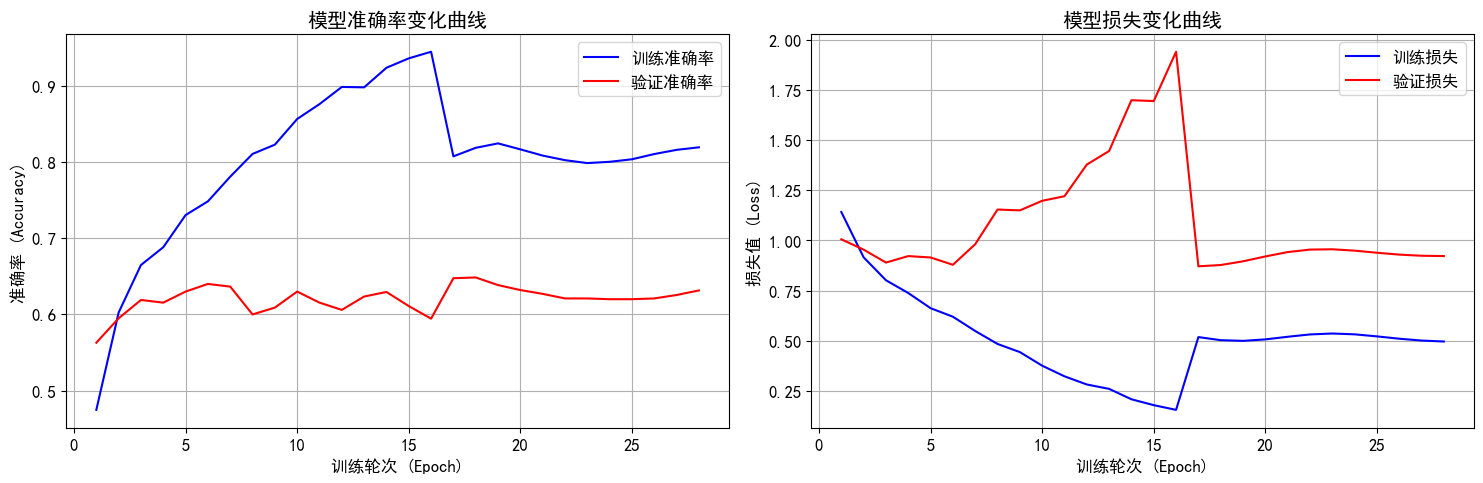

In [170]:
print("将语句标准固定分段后的结果如下：")
plot_training_history(history3, history4)

In [172]:
def create_segment_model(num_segments, DIM, num_classes):
    """
    创建处理分段数据的模型
    """
    # 输入形状: (batch_size, num_segments, DIM)
    input_layer = Input(shape=(num_segments, DIM))
    
    # 方案1: 使用1D卷积处理分段序列
    # x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    # x = MaxPooling1D(pool_size=2)(x)
    # x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    # x = GlobalAveragePooling1D()(x)
    
    # 方案2: 使用RNN处理分段序列
    x = LSTM(128, return_sequences=True)(input_layer)
    x = LSTM(64)(x)
    
    # 方案3: 直接展平（简单但有效）
    # x = Flatten()(input_layer)
    
    # 全连接层
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

segment_model = create_segment_model(num_segments, DIM, num_classes=4)

checkpoint2 = ModelCheckpoint(
             "best_segment_model_lstm.h5",
             monitor="val_accuracy",
            save_best_only = True,
            verbose = 1
            )

early_stop2 = EarlyStopping(
             monitor="val_accuracy",
             patience = 10,
             restore_best_weights = True,
             verbose = 1
             )

In [176]:
history6 = segment_model.fit(
    train_X_fixed, train_Y_fixed,
    validation_data=(test_X_fixed, test_Y_fixed),
    batch_size=6000,
    epochs=100,
    callbacks=[checkpoint2, early_stop2],

)

将语句标准固定分段后，并采用LSTM的结果如下：


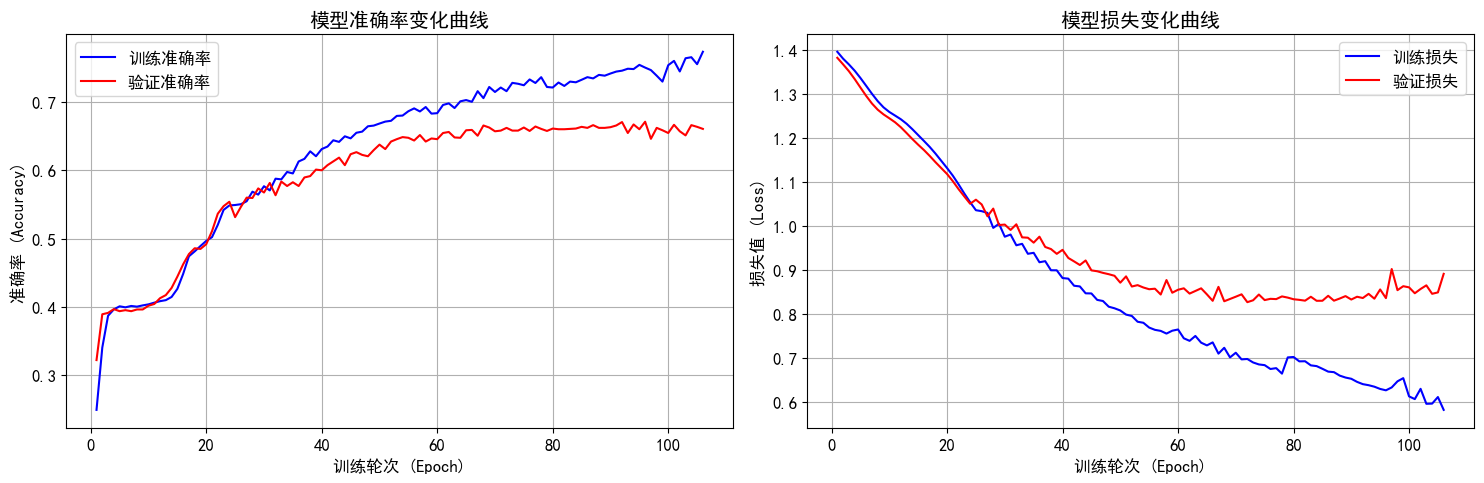

In [175]:
print("将语句标准固定分段后，并采用LSTM的结果如下：")
plot_training_history(history5, history6)

# 总结 ：  
## 简单将词矩阵求平均损失了大量信息，采用分段后有明显提升，最后采用LSTM方法，将预测精度提高到了接近70%

In [178]:
test_loss, test_accuracy = segment_model.evaluate(test_X_fixed, test_Y_fixed, verbose=0)

# 突出显示最终测试精度
print("=" * 50)
print(f"🚀 **测试集最高精度: {test_accuracy*100:.2f}%** 🚀")
print("=" * 50)

🚀 **测试集最高精度: 67.08%** 🚀


# 展示结果（由DeepSeek完成代码）

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import load_model

def evaluate_model(model, X_test, y_test, label_mapping=None):
    """
    全面评估模型性能
    
    参数:
    - model: 训练好的模型
    - X_test: 测试数据
    - y_test: 测试标签（整数形式）
    - label_mapping: 标签映射字典（可选）
    """
    
    # 1. 模型预测
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # 确保y_test是整数形式
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_int = np.argmax(y_test, axis=1)
    else:
        y_test_int = y_test.astype(int)
    
    # 2. 计算准确率
    accuracy = accuracy_score(y_test_int, y_pred)
    print(f"模型准确率: {accuracy:.4f}")
    
    # 3. 详细分类报告
    print("\n详细分类报告:")
    if label_mapping:
        target_names = [label_mapping[i] for i in range(len(label_mapping))]
        print(classification_report(y_test_int, y_pred, target_names=target_names))
    else:
        print(classification_report(y_test_int, y_pred))
    
    # 4. 混淆矩阵
    plt.figure(figsize=(10, 8))
    if label_mapping:
        labels = [label_mapping[i] for i in range(len(label_mapping))]
        cm = confusion_matrix(y_test_int, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    else:
        cm = confusion_matrix(y_test_int, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    plt.title('混淆矩阵')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.tight_layout()
    plt.show()
    
    # 5. 各类别精确率、召回率和F1分数
    precision = precision_score(y_test_int, y_pred, average=None)
    recall = recall_score(y_test_int, y_pred, average=None)
    f1 = f1_score(y_test_int, y_pred, average=None)
    
    print("\n各类别详细指标:")
    for i in range(len(precision)):
        if label_mapping:
            label_name = label_mapping[i] if i in label_mapping else f"类别{i}"
        else:
            label_name = f"类别{i}"
        print(f"{label_name}: 精确率={precision[i]:.4f}, 召回率={recall[i]:.4f}, F1分数={f1[i]:.4f}")
    
    # 6. 宏平均和微平均
    macro_precision = precision_score(y_test_int, y_pred, average='macro')
    macro_recall = recall_score(y_test_int, y_pred, average='macro')
    macro_f1 = f1_score(y_test_int, y_pred, average='macro')
    
    micro_precision = precision_score(y_test_int, y_pred, average='micro')
    micro_recall = recall_score(y_test_int, y_pred, average='micro')
    micro_f1 = f1_score(y_test_int, y_pred, average='micro')
    
    print(f"\n宏平均: 精确率={macro_precision:.4f}, 召回率={macro_recall:.4f}, F1分数={macro_f1:.4f}")
    print(f"微平均: 精确率={micro_precision:.4f}, 召回率={micro_recall:.4f}, F1分数={micro_f1:.4f}")
    
    # 7. 预测结果示例
    print("\n预测结果示例 (前10个样本):")
    for i in range(min(10, len(y_test_int))):
        true_label = y_test_int[i]
        pred_label = y_pred[i]
        confidence = y_pred_proba[i][pred_label]
        
        if label_mapping:
            true_label_name = label_mapping[true_label] if true_label in label_mapping else f"类别{true_label}"
            pred_label_name = label_mapping[pred_label] if pred_label in label_mapping else f"类别{pred_label}"
        else:
            true_label_name = f"类别{true_label}"
            pred_label_name = f"类别{pred_label}"
        
        status = "✓" if true_label == pred_label else "✗"
        print(f"样本{i+1}: 真实={true_label_name}, 预测={pred_label_name}, 置信度={confidence:.4f} {status}")
    
    # 8. 计算正确率
    correct_predictions = np.sum(y_test_int == y_pred)
    total_predictions = len(y_test_int)
    print(f"\n总样本数: {total_predictions}")
    print(f"正确预测: {correct_predictions}")
    print(f"错误预测: {total_predictions - correct_predictions}")
    print(f"正确率: {correct_predictions/total_predictions:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'confusion_matrix': cm,
        'y_true': y_test_int,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# 可视化训练历史
def plot_training_history(history):
    """
    绘制训练历史图表
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 准确率图表
    ax1.plot(history.history['accuracy'], label='训练准确率')
    ax1.plot(history.history['val_accuracy'], label='验证准确率')
    ax1.set_title('模型准确率')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('准确率')
    ax1.legend()
    
    # 损失图表
    ax2.plot(history.history['loss'], label='训练损失')
    ax2.plot(history.history['val_loss'], label='验证损失')
    ax2.set_title('模型损失')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('损失')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# 多类别ROC曲线（仅适用于二分类或少数类别）
def plot_multiclass_roc(y_true, y_pred_proba, n_classes, label_mapping=None):
    """
    绘制多类别ROC曲线（仅适用于类别较少的情况）
    """
    if n_classes > 10:
        print("类别过多，不绘制ROC曲线")
        return
    
    plt.figure(figsize=(10, 8))
    
    # 为每个类别计算ROC曲线和AUC
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制每个类别的ROC曲线
    for i in range(n_classes):
        if label_mapping and i in label_mapping:
            label_name = label_mapping[i]
        else:
            label_name = f"类别 {i}"
        plt.plot(fpr[i], tpr[i], label=f'{label_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='随机分类器')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假正率')
    plt.ylabel('真正率')
    plt.title('多类别ROC曲线')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

模型评估结果
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
模型准确率: 0.6708

详细分类报告:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       510
           1       0.73      0.62      0.67       470
           2       0.63      0.69      0.66       503
           3       0.56      0.59      0.57       516

    accuracy                           0.67      1999
   macro avg       0.68      0.67      0.67      1999
weighted avg       0.68      0.67      0.67      1999



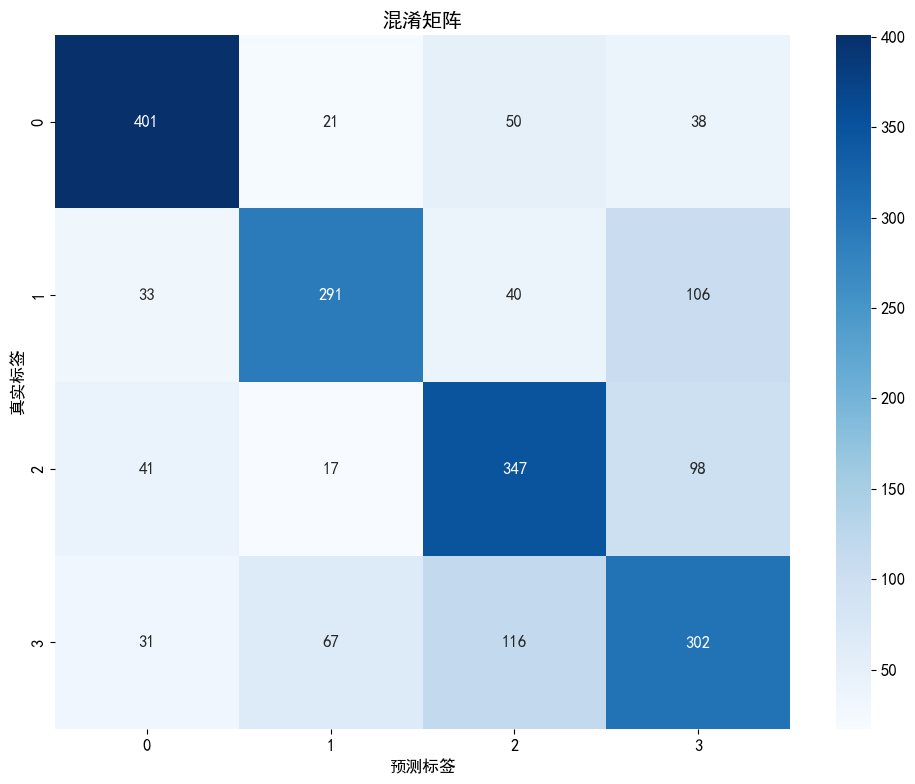


各类别详细指标:
类别0: 精确率=0.7925, 召回率=0.7863, F1分数=0.7894
类别1: 精确率=0.7348, 召回率=0.6191, F1分数=0.6721
类别2: 精确率=0.6275, 召回率=0.6899, F1分数=0.6572
类别3: 精确率=0.5551, 召回率=0.5853, F1分数=0.5698

宏平均: 精确率=0.6775, 召回率=0.6701, F1分数=0.6721
微平均: 精确率=0.6708, 召回率=0.6708, F1分数=0.6708

预测结果示例 (前10个样本):
样本1: 真实=类别2, 预测=类别2, 置信度=0.5854 ✓
样本2: 真实=类别2, 预测=类别2, 置信度=0.6150 ✓
样本3: 真实=类别1, 预测=类别1, 置信度=0.9614 ✓
样本4: 真实=类别0, 预测=类别0, 置信度=0.8114 ✓
样本5: 真实=类别1, 预测=类别3, 置信度=0.5297 ✗
样本6: 真实=类别3, 预测=类别2, 置信度=0.4398 ✗
样本7: 真实=类别3, 预测=类别3, 置信度=0.6840 ✓
样本8: 真实=类别0, 预测=类别0, 置信度=0.9713 ✓
样本9: 真实=类别0, 预测=类别0, 置信度=0.9503 ✓
样本10: 真实=类别0, 预测=类别0, 置信度=0.8868 ✓

总样本数: 1999
正确预测: 1341
错误预测: 658
正确率: 0.6708


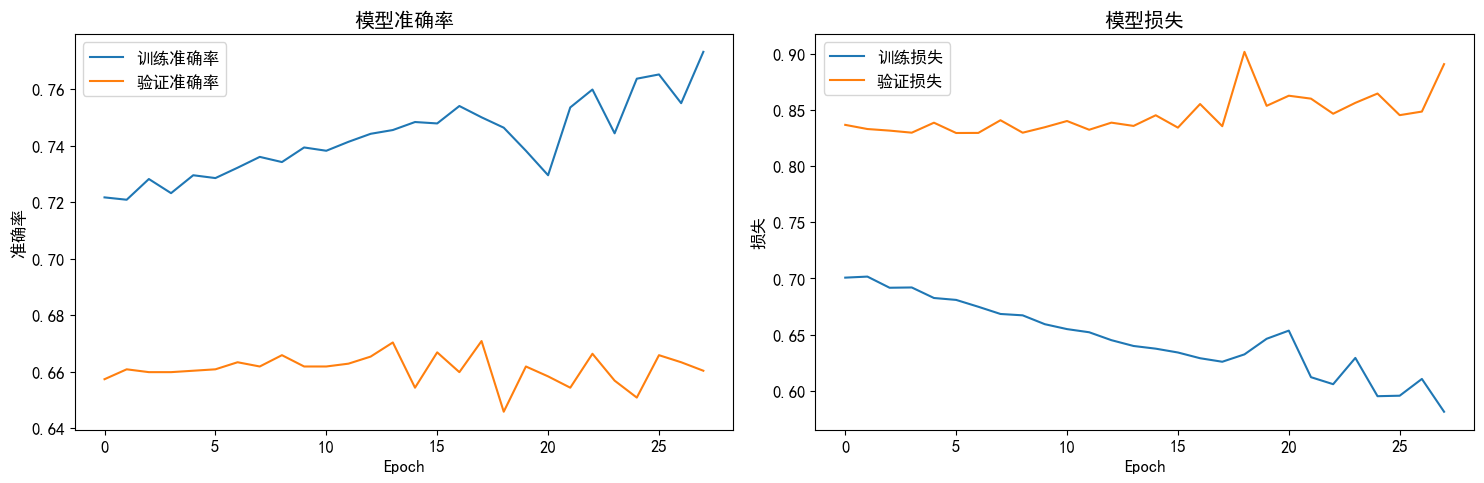

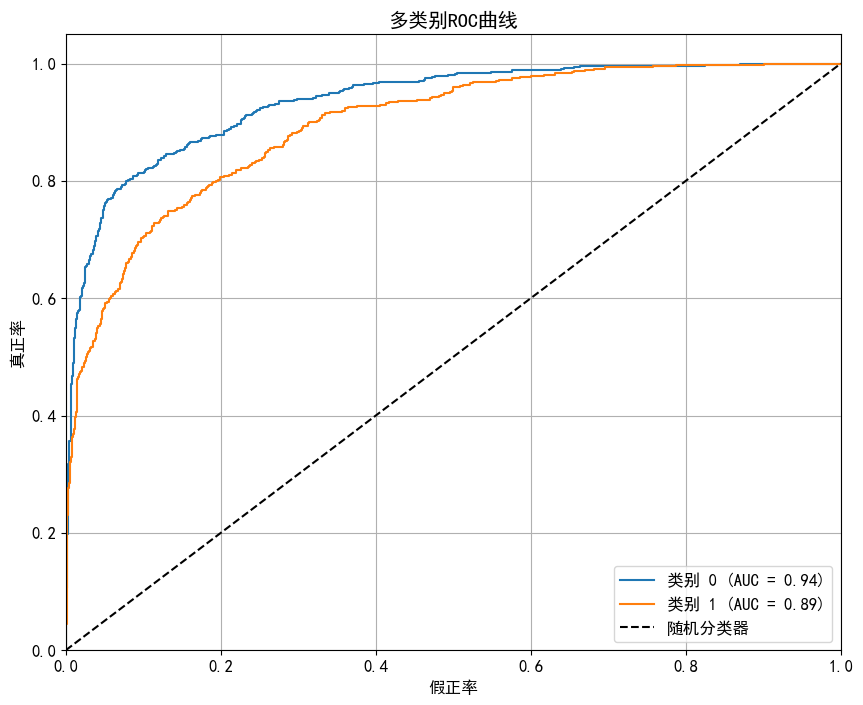


预测结果已保存到 'model_predictions.csv'

模型性能总结
总体准确率: 0.6708
宏平均F1分数: 0.6721
微平均F1分数: 0.6708


In [186]:
# 1. 加载最佳模型（如果使用了检查点）
# best_model = load_model("best_segment_model.h5")

# 或者使用当前训练的模型
best_model = segment_model

# 2. 评估模型
print("=" * 50)
print("模型评估结果")
print("=" * 50)

# 假设你有标签映射（如果没有，设为None）
# label_mapping = {0: "类别A", 1: "类别B", 2: "类别C", 3: "类别D"}

results = evaluate_model(best_model, test_X_fixed, test_Y_fixed, label_mapping=None)

# 3. 绘制训练历史（如果有）
if 'history6' in locals():
    plot_training_history(history6)

# 4. 绘制ROC曲线（仅适用于类别较少的情况）
if len(np.unique(test_Y_fixed)) <= 10:
    plot_multiclass_roc(
        results['y_true'], 
        results['y_pred_proba'], 
        len(np.unique(test_Y_fixed)), 
        label_mapping=None
    )

# 5. 保存评估结果
import pandas as pd

# 创建详细的结果数据框
results_df = pd.DataFrame({
    '真实标签': results['y_true'],
    '预测标签': results['y_pred'],
    '预测概率': [max(proba) for proba in results['y_pred_proba']],
    '是否正确': results['y_true'] == results['y_pred']
})

# 保存到CSV文件
results_df.to_csv('model_predictions.csv', index=False, encoding='utf-8-sig')
print("\n预测结果已保存到 'model_predictions.csv'")

# 6. 输出总结
print("\n" + "=" * 50)
print("模型性能总结")
print("=" * 50)
print(f"总体准确率: {results['accuracy']:.4f}")
print(f"宏平均F1分数: {results['macro_f1']:.4f}")
print(f"微平均F1分数: {results['micro_f1']:.4f}")

In [187]:
# 分析预测错误的样本
def analyze_errors(results, X_test_original=None, test_sentences=None):
    """
    分析预测错误的样本
    """
    errors_mask = results['y_true'] != results['y_pred']
    error_indices = np.where(errors_mask)[0]
    
    print(f"\n错误分析: 共 {len(error_indices)} 个错误预测样本")
    
    if len(error_indices) > 0:
        print("\n前10个错误预测样本:")
        for i, idx in enumerate(error_indices[:10]):
            true_label = results['y_true'][idx]
            pred_label = results['y_pred'][idx]
            confidence = results['y_pred_proba'][idx][pred_label]
            
            print(f"样本 {idx}: 真实=类别{true_label}, 预测=类别{pred_label}, 置信度={confidence:.4f}")
            
            # 如果有原始句子，显示它们
            if test_sentences is not None and idx < len(test_sentences):
                print(f"   句子: {' '.join(test_sentences[idx][:50])}...")  # 只显示前50个词

# 使用错误分析
analyze_errors(results, test_sentences=test_splitX)


错误分析: 共 658 个错误预测样本

前10个错误预测样本:
样本 4: 真实=类别1, 预测=类别3, 置信度=0.5297
   句子: 江苏省 沛县 人民法院   
 
 刑   事   判   决   书   
 
 （ 2015 ） 沛刑 初字 第 448 号   
 
 公诉 机关 江苏省 沛县 人民检察院 。   
 
 被告人 付某 ， 徐州市 宁丰 木业 有限公司 工人 。 因涉嫌 犯 过失...
样本 5: 真实=类别3, 预测=类别2, 置信度=0.4398
   句子: 广东省 东源县 人民法院   
 
 刑   事   判   决   书   
 
 （ 2015 ） 河东 法刑 初字 第 240 号   
 
 公诉 机关 广东省 东源县 人民检察院 。   
 
 被告人 缪 某某 ， 男 ， 1987 年 6 月 3...
样本 10: 真实=类别1, 预测=类别3, 置信度=0.5645
   句子: 山东省 曹县 人民法院   
 
 刑   事   判   决   书   
 
 （ 2018 ） 鲁 1721 刑初 330 号   
 
 公诉 机关 山东省 曹县 人民检察院 。   
 
 被告人 李如仓 ， 男 ， 1980 年 1 月 9 日出 生于...
样本 18: 真实=类别1, 预测=类别2, 置信度=0.4521
   句子: 安阳市 龙安区 人民法院   
 
 刑   事   判   决   书   
 
 （ 2013 ） 龙少 刑初 字 第 2 号   
 
 公诉 机关 安阳市 龙安区 人民检察院 。   
 
 被告人 赵 某某 ， 男 ， 汉族 ， 初中文化 。 因涉嫌...
样本 21: 真实=类别2, 预测=类别3, 置信度=0.5308
   句子: 湖北省 孝感市 孝南区 人民法院   
 
 刑   事   附   带   民   事   判   决   书   
 
 ( 2017 ) 鄂 0902 刑初 66 号   
 
 公诉 机关 孝感市 孝南区 人民检察院 。   
 
 附带 民事诉讼 原告人...
样本 25: 真实=类别2, 预测=类别1, 置信度=0.4119
   句子: 湖南省 中方县 人民法院   
 
 刑   事   判   决   书   
 
 